In [1]:
# Math Stuff
import numpy as np
import pandas as pd
import scipy.stats as stat

# Proceesing librairies
from natsort import natsorted
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import imblearn

# Side Stuff
import joblib
import warnings
import colorama as col
import pyttsx3
engine = pyttsx3.init()
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

# Random Seed
seed_value = 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


# Technical analysis
from finta import TA

# Plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

# Time Stuff
import time
import datetime as dt

print('Imblearn version ',imblearn.__version__)
print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Tensorflow version ',tf.__version__)
print('Joblib version ',joblib.__version__)

warnings.filterwarnings('ignore')


Imblearn version  0.7.0
Pandas version  1.2.2
Numpy version  1.19.5
Tensorflow version  2.4.1
Joblib version  1.0.1


In [5]:
TIK = ['AUD','NZD','GBP','JPY','CHF','CAD','SEK','NOK','ILS','MXN','USD','EUR']
RATE = [0.776,0.721,1.3912,1/105.91,1/0.892,1/1.2681,1/8.2884,1/8.4261,1/3.2385,1/20.1564,1,1.21]
df_ratefx = pd.DataFrame(index=TIK)
df_ratefx['rate'] = RATE

#scaler = Normalizer()
scaler = MinMaxScaler()
# scaler = StandardScaler()

x = 'EUR/USD'
_period = 'm5'
_period2 = 'H1'
_ticker = x.replace('/','')
_start = '2010-01-01' # start the train there '2010-01-01'
_mid = '2016-06-30' # stop the train and begin the test there '2016-08-31'
_stop = '2018-12-31' # stop the test there. After that, it is kept for oos '2017-12-31'
_last = '2021-04-29' # '2020-12-31'
_nb_bougie_exit = 555555555555555
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 1
_trigger_rsi = 0
_verbose = 0
_cash_ini = 200000
_target = 0.002
_sl = 0.001
_exposure = 1
_rate = df_ratefx.loc[x[4:],'rate']
_size = _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0


In [6]:


def bt(price,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_save=0,_bt_report=0,_trigger_rsi=_trigger_rsi):
    engine = pyttsx3.init()

    print(col.Fore.YELLOW)
    print('\n_________________________________________________\n')
    print('__________________________________')
    print('     ___ Period 1 : => ', _period,' ___')
    print('     ___ Period 2 : => ', _period2,' ___')
    print('__________________________________')
    print('Ca$h Ini :',_cash_ini)
    print('Date début:',_year_bottom)
    print('Date fin :',_year_top)
    print('Etat verbose :',_verbose)
    print('Nombre Bougies Exit :',_nb_bougie_exit)
    print('Target :',_target)
    print('Stop Loss :',_sl)
    print('Trigger Reengage :',_trigger_reengage)
    print('Trigger Target :',_trigger_target)
    print('Trigger Inverse :',_trigger_invers)
    print('Trigger StopLoss :',_trigger_sl)
    print('Trigger RSI :',_trigger_rsi)
    print('Exposure :',_exposure)
    print('_bt_report : ',_bt_report)
    print('Verbose : ',_verbose)
    print('Trigger Spread :',_trigger_spread)
    print('Save : ',_save)
    print('\n_________________________________________________\n')
    print(col.Style.RESET_ALL)

    engine.say("Backtesting in progress")
    engine.runAndWait()


    _t1 = dt.datetime.now()
    print('Début des opérations horodatée à',dt.datetime.now())
    print('\n _trigger_rsi :',_trigger_rsi,'\n')

    _total = 0
    _cash = _cash_ini
    _pnl = 0
    _tracker = 0

    DATE = []
    CONTRACT = []
    OPEN_POZ = []
    CLOSE_POZ = []
    RATE_OPEN_POZ = []
    RATE_CLOSE_POZ = []
    PNL_LAT = []
    PNL_REAL = []
    TOTAL_OPEN = []
    TOTAL_CLOSE = []
    PRICE_BUY = []
    PRICE_SELL = []
    DER_POZ = []
    TOTAL_PNL_LAT = []
    TOTAL_PNL_REAL = []
    EXPO_MAX = []
    TRACKER = []
    TRADE_DURATION = []
    PRICE_BUY = []
    PRICE_SELL = []
    EQUITY = []
    CASH = []
    
    df_resultats = pd.DataFrame(index=['Equity','Nbre Winners','Nbre winners long','Nbre winners short','Nbre Loosers','Nbre loosers long','Nbre loosers short','Max lenght of trade','Min lenght of trade',\
        'Average lenght of trade','Cumul pnl'])
    
    print('\nChargement de la nouvelle base\n\n')

    engine.say("קדימה")
    engine.runAndWait()

    print(col.Fore.MAGENTA,'Le rate du ticker',x,'est à ',_rate,col.Style.RESET_ALL)

    price = price[(price.index >= _year_bottom) & (price.index <= _year_top)]
    print('Bases chargées')

    print('TETEL process effectué')

    print(col.Fore.CYAN,'ENTERING THE BACKTEST',col.Style.RESET_ALL)

    time.sleep(0.2)
        
    price = price.dropna()

    _position = 0
    _equity = 0
    _nbtransactions = 0
    backtest_graph = pd.DataFrame()

    _winner = 0
    _looser = 0
    _longwinner = 0
    _longlooser = 0
    _shortwinner = 0
    _shortlooser = 0
    _index_entry = 0
    
    _average_duration = 0
    _total = 0

    

    _open_buy = 0
    _open_sell = 0

    for i in tqdm(range(0,len(price))):

        _size = _cash_ini / df_ratefx.loc[x[:3],'rate']

        ##### POSITIONS EN L'AIR 
        if i >= (len(price)-1) and (_position == 1 or _position == -1) :

            if _position == -1:
                _position = 99
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_sell
                    _longwinner+=_open_sell
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                
                TRADE_DURATION.append(i - _index_entry)
                
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_sell,'position closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            if _position == 1:

                _position = 99
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_buy,'positions closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
        
        # SI PAS DE POSITION
        if _position == 0:
            # BUY SIGNAL
            if  price.Signal[i] == 1: 
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 

            # SELL SIGNAL
            elif price.Signal[i] == -1: 
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            else :
                _pnl = 0
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                PNL_LAT.append(0)
                PNL_REAL.append(0)
                continue
        
        # SI POSITION LONG
        elif _position == 1:

            ### RE_ENGAGE BUY ON VALID SIGNAL
            if price.Signal[i] == 1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1\
                 and _open_buy < _exposure :
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position (REENG) 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
            
            ### CLOSE LONG ON RSI DROUP OUT
            if _trigger_rsi == 1 and price.MYRSI_2[i] > 85:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (RSI) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (RSI) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            ### CLOSE LONG ON INVERSE SIGNAL
            if price.Signal[i] == -1 and _trigger_invers == 1:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            ### CLOSE LONG ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            # CLOSE LONG ON TARGET
            if (float(price.HighBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) >= _target and _trigger_target == 1:
                _position = 0
                _pnl = (price.HighBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            # CLOSE LONG ON STOP LOSS
            if (float(price. LowBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) <= - _sl and _trigger_sl == 1:
                _position = 0
                _pnl = (price.LowBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            else:

                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 
 
        # SI POSITION SHORT
        elif _position == -1:

            ### RE-ENGAGE SELL ON VALID SIGNAL
            if price.Signal[i] == -1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1 \
                and _open_sell < _exposure :
                
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position (REENG) 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            ### CLOSE SHORT ON RSI DROUP OUT
            if _trigger_rsi == 1 and price.MYRSI_2[i] < 15:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (RSI) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (RSI) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON INVERSE SIGNAL
            if price.Signal[i] == 1 and _trigger_invers == 1:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TARGET
            if (float(price.LowAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) <= -_target and _trigger_target == 1:
                _position = 0
                _pnl = - (price.LowAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON STOP LOSS
            if (float(price.HighAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) > _sl and _trigger_sl == 1:
                _position = 0
                _pnl = - (price.HighAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            else:

                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _equity = _cash + _pnl

                EQUITY.append(_equity)
                CASH.append(_cash)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
        

    try:
        _average_duration = round(sum(TRADE_DURATION)/len(TRADE_DURATION),2)
        _max_duration = max(TRADE_DURATION)
        _min_duration = min([item for item in TRADE_DURATION if item !=0])

    except:
        print("(No Duration)") 
        _average_duration = 'NA'
        _max_duration = 0.00002
        _min_duration = 0.00001 
    print(col.Fore.BLUE,'For ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    if _total > 0:              
        print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.GREEN,round(_total,2),'. En ',\
            _nbtransactions,col.Style.RESET_ALL,' transactions.' )
    else:
        print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.RED,round(_total,2),'. En ',\
            _nbtransactions,col.Style.RESET_ALL,' transactions.' ) 
    print(col.Fore.GREEN,"\nWinners Number :",_winner,col.Style.RESET_ALL)
    print(col.Fore.RED,"\nLoosers number :",_looser,col.Style.RESET_ALL)

    backtest_graph['Equity'] = EQUITY

    df_resultats[x] = [(round(_equity,2)),(_winner),(_longwinner),(_shortwinner),(_looser),(_longlooser),(_shortlooser),(_max_duration),(_min_duration),(_average_duration),(_total)]

    DER_POZ.append(_pnl)

    engine.say("Finito caucau")
    engine.runAndWait()
    _t2 = dt.datetime.now()
    print("BT's execution time",str((_t2 - _t1)))
    df_historical = pd.DataFrame()
    df_historical = pd.DataFrame(index=DATE)
    df_historical['Contract'] = CONTRACT
    df_historical['Open_Poz'] = OPEN_POZ
    df_historical['Close_Pos'] = CLOSE_POZ
    df_historical['Rate_Open_Poz'] = RATE_OPEN_POZ 
    df_historical['Rate_Close_Poze'] = RATE_CLOSE_POZ
    df_historical['Pnl_Lat'] = TOTAL_PNL_LAT
    df_historical['Pnl_Real'] = TOTAL_PNL_REAL
    df_historical = df_historical.sort_index()
    _generated_cash = round(df_historical.Pnl_Real.sum(),2)
    _generated_cash_perc = round((_generated_cash / _cash_ini) * 100,2)
    print(col.Fore.YELLOW,x,col.Fore.BLUE,'results',col.Style.RESET_ALL)
    print(col.Fore.MAGENTA,'Tested Period',_year_bottom,' à',_year_top,col.Style.RESET_ALL)
    print(col.Fore.CYAN,'Total Number of trades',max([sum(TOTAL_OPEN),sum(TOTAL_CLOSE)]),col.Style.RESET_ALL)
    if _generated_cash <= 0:
        print('Started Cash :',_cash_ini)
        print('P&L in currency:',col.Fore.RED,str(_generated_cash)+'$',col.Style.RESET_ALL)
        print('P&L in %:',col.Fore.RED,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

    else:
        print('Started Cash :',_cash_ini)
        print('P&L  in currency:',col.Fore.GREEN,str(_generated_cash)+'$',col.Style.RESET_ALL)
        print('P&L in %:',col.Fore.GREEN,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

    print('Average trade duration',_average_duration)
    print('# Winners ',df_resultats.T['Nbre Winners'].sum())
    print('# Winners long ',df_resultats.T['Nbre winners long'].sum())
    print('# Winners short ',df_resultats.T['Nbre winners short'].sum())

    print('# Loosers ',df_resultats.T['Nbre Loosers'].sum())
    print('# Loosers  long',df_resultats.T['Nbre loosers long'].sum())
    print('# Loosers  short',df_resultats.T['Nbre loosers short'].sum())
    print('Cumulated gains',round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum(),2))
    print('Cumulated losses',round(df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2))
    print(col.Fore.BLUE,'PROFIT FACTOR : ',\
        abs(round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum()/df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2)),col.Style.RESET_ALL)
    try:
        print(col.Fore.CYAN,'Winners Ratio :',\
            round((df_resultats.T['Nbre Winners'].sum()*100)/(df_resultats.T['Nbre Loosers'].sum()+df_resultats.T['Nbre Winners'].sum()),2),\
                '%',col.Style.RESET_ALL)
    except:
        print(col.Fore.CYAN,'Winners Ratio  :None',col.Style.RESET_ALL)
    try:
        print('Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))),2))
        print('% Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))) * 100 / _cash_ini,2))
    except:
        print('No winner')
    try:
        print('Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))),2))
        print('% Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))) / _cash_ini * 100,2))
    except:
        print('No looser')
    try:
        print('Average pnl',round(sum(PNL_REAL)/sum(TOTAL_OPEN),2))
        print('% Average pnl',round((sum(PNL_REAL)/len(set(PNL_REAL))) / _cash_ini * 100,2))
    except:
        print('No trade')
    
    print('Number of opened trades',sum(TOTAL_OPEN))
    print('Number of closed trades',sum(TOTAL_CLOSE))
    try:
        print('Max Exposure',max(EXPO_MAX),'x ',_size,'= ',max(EXPO_MAX)*_size,'$')
    except:
        print("Pas de trade => Pas d'exposure")
    candle_feedback = pd.DataFrame(index = price.index)
    candle_feedback['Symbol'] = x
    candle_feedback['Size'] = _size
    candle_feedback[_ticker] = EQUITY
    print('\n_bt_report :',_bt_report,'\n')
    
    if _bt_report == 1:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_oos.dag')

    elif _bt_report == 2:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_bt_bt.dag')
    
    elif _bt_report == 3:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_ai.dag')
    
    elif _bt_report == 4:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_custom.dag')
        
    return(TRACKER,df_resultats.T['Nbre Loosers'].sum())

In [7]:
def klines(df):
    _condition1 = df.Close >= df.Open
    df['Color'] = np.where(_condition1,1,-1)
    _condition2 = df.Color = 1
    df['UpperShadow'] = np.where(_condition2,(df.High-df.Close),(df.High-df.Open))
    df['LowerShadow'] = np.where(_condition2,(df.Open-df.Low),(df.Close-df.Low))
    df['Body'] = abs(df.Close-df.Open)
    return (df)

In [8]:
def undersample2(df):
    
    print('Avant Resampling :')
    print('Classe 0',df[df.Valid==0].shape[0])
    print('Classe 1',df[df.Valid==1].shape[0])

    # Class count
    count_class_0, count_class_1 = df.Valid.value_counts()
    # Divide by class
    df_class_0 = df[df.Valid== 0]
    df_class_1 = df[df.Valid == 1]

    df_class_0_under = df_class_0.sample(int((count_class_1)*.65))
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    df = df.sort_index()
    print('Random under-sampling:')
    print(df.Valid.value_counts())

    # Classify and report the results
    print('\nAprès resample:')
    print('Classe 0',df[df.Valid==0].shape[0])
    print('Classe 1',df[df.Valid==1].shape[0])
    return df

def oversample2(df):
    from imblearn.over_sampling import SMOTE
    print('Avant Resampling :')
    print('Classe 0',df[df.Valid==0].shape[0])
    print('Classe 1',df[df.Valid==1].shape[0])
    
    
    # Class count
    count_class_0, count_class_1 = df.Valid.value_counts()
    # Divide by class
    df_class_0 = df[df.Valid== 0]
    df_class_1 = df[df.Valid == 1]

    oversample = SMOTE()
    df, y = oversample.fit_resample(df, df.Valid)
    df = df.sort_index()
    print('Random under-sampling:')
    print(df.Valid.value_counts())

    # Classify and report the results
    print('\nAprès resample:')
    print('Classe 0',df[df.Valid==0].shape[0])
    print('Classe 1',df[df.Valid==1].shape[0])
    return df


In [9]:
def split_df(df):
    """[Split the dtaframe in train/test/oos and reduce train and test to dataframe with signal!=0 only]

    Args:
        df ([pandas]): [the datframe to split already featured]
        _start ([date]): [beginning of the df]
        _mid ([date]): [stop of the train and beginning of the test]
        _stop ([date]): [stop of the test and beginning of the oos]
        _last ([date]): [end of the oos]
    """    
    df = df.dropna()
    df['Date'] = pd.to_datetime(df.index)
    
    df_train = df[(df.Date>=_start)&(df.Date<=_mid)]
    df_test = df[(df.Date>_mid)&(df.Date<=_stop)]
    df_oos = df[(df.Date>_stop)&(df.Date <= _last)]
    df_train = df_train.drop(['Date'],axis=1)
    df_test = df_test.drop(['Date'],axis=1)
    df_oos = df_oos.drop(['Date'],axis=1)
    return(df_train, df_test,df_oos)

In [10]:
def strategy(df):
    ##### CONDITIONS LONG
    _condition_1 = (df.slow_K5 < 20) & (df.slow_K5.shift(1) < df.slow_D5.shift(1)) & (df.slow_K5 > df.slow_D5)

    ##### CONDITIONS SHORT
    _condition_1_bar = (df.slow_K5 > 80) & (df.slow_K5.shift(1) > df.slow_D5.shift(1)) & (df.slow_K5 < df.slow_D5)

    ##### 1 condition
    df['Signal'] = np.where(_condition_1,1,np.where(_condition_1_bar,-1,0))
    try:
        df = df.drop(['Symbol','Date','DateIndex','SB_Gamma'], axis=1)
    except:
        pass
    return(df.sort_index(axis=0)) 

def strategy5(df,_window=40):

    #df['RSI_2'] = TA.RSI(ohlc=df,int=2,str='Close')

    df['Window_High_Ask'] = df.HighAsk.iloc[::-1].rolling(_window).max().iloc[::-1] # Limite SL Short
    df['Window_High_Bid'] = df.HighBid.iloc[::-1].rolling(_window).max().iloc[::-1] # Limite Target Long
    df['Window_Low_Ask'] = df.LowAsk.iloc[::-1].rolling(_window).min().iloc[::-1] # Limite Target Short
    df['Window_Low_Bid'] = df.LowBid.iloc[::-1].rolling(_window).min().iloc[::-1] # Limite SL Long
    df['Window_sl_Short'] = df.CloseBid + (df.CloseBid * _sl) # Short pour SL
    df['Window_sl_Long'] = df.CloseAsk - (df.CloseAsk * _sl) # Long pour SL
    df['Window_tp_Short'] = df.CloseBid - (df.CloseBid * _target) # Short pour TP
    df['Window_tp_Long'] = df.CloseAsk + (df.CloseAsk * _target) # Long pour TP

    ##### CONDITIONS LONG
    _condition_1 = (df['Window_tp_Long'] <= df['Window_High_Bid']) & (df['Window_sl_Long'] <= df['Window_Low_Bid'])

    ##### CONDITIONS SHORT
    _condition_1_bar = (df['Window_tp_Short'] >= df['Window_Low_Ask']) & (df['Window_sl_Short'] >= df['Window_High_Ask'])

    ##### 1 condition
    df['Signal'] = np.where(_condition_1,1,np.where(_condition_1_bar,-1,0))
    df = df.drop(['Symbol','Date','DateIndex','Window_High_Ask','Window_High_Bid','Window_Low_Ask','Window_Low_Bid','Window_sl_Short','Window_sl_Long','Window_tp_Short','Window_tp_Long'], axis=1)
    return(df.sort_index(axis=0))

In [ ]:
%%time

_nb_looser = 10000000000
TRACKER = []
_year_bottom = _start
_year_top = _stop


df = joblib.load('BASES/EURUSD_m5')


df = klines(df)

df = strategy(df)

print(df.Signal.value_counts())

print()
print(col.Fore.CYAN,'###############################################################################################')
print(' #################################### TRAIN/TEST WITHOUT AI ####################################')
print(' ###############################################################################################',col.Style.RESET_ALL)


TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)


print()
print(col.Fore.BLUE,'###############################################################################################')
print(' #################################### DENOISING & ENHANCING ####################################')
print(' ###############################################################################################',col.Style.RESET_ALL)
while _nb_looser > 0 :
    
    df['TRACKER'] = np.where(df.index.isin(TRACKER),1,0)
    df['Valid'] = np.where(((df.Signal!=0)&(df.TRACKER==1)),1,0)
    df['Signal'] = np.where(((df.Valid==1)&(df.Signal==1)),1,np.where(((df.Valid==1)&(df.Signal==-1)),-1,0))
    ##### Purification of signal by denoising and enhancing
    TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)

print('Shape de features',df.shape)
df['TRACKER'] = np.where(df.index.isin(TRACKER),1,0)
df = strategy(df)
df_raw = df.copy()

df = df[df.Signal!=0]

# Si pas de signal, Valid à 0. Si signal + TRACKER, Valid à 1; et si Signal sans TRACKER, 2
_condition1 = ((df.Signal != 0) & (df.TRACKER == 1))
_condition2 = ((df.Signal != 0 )& (df.TRACKER == 0))

df['Valid'] = np.where(_condition1,1,np.where(_condition2,2,0))

print(df.Valid.value_counts())

#df = df[df.Signal!=0]

#df = undersample2(df)

joblib.dump(df,'BASES/df_prep_EURUSD_m5')
joblib.dump(df_raw,'BASES/df_raw_EURUSD_m5')


## DEBUT BASE PREPAREE

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation,Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision, Metric
from keras.utils import to_categorical
# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [185]:
%%time
df = joblib.load('BASES/df_prep_EURUSD_m5')
df_raw = joblib.load('BASES/df_raw_EURUSD_m5')
df.shape

CPU times: user 207 ms, sys: 326 ms, total: 533 ms
Wall time: 587 ms


(36675, 66)

## FEATURE TRANSFORMATION

In [186]:
COLUMNS = ['Valid','TRACKER','Signal']
for _column in df.columns:
    if _column  in COLUMNS:
        print(_column)

Signal
TRACKER
Valid


In [187]:
%%time
# Diff
COLUMNS = ['Valid','TRACKER','Signal']
for _column in df.columns:
    if _column not in COLUMNS:
        df['D_'+_column] = df[_column] - df[_column].shift()
df = df.dropna()

CPU times: user 102 ms, sys: 27.3 ms, total: 130 ms
Wall time: 109 ms


In [188]:
%%time
COLUMNS = ['Valid','TRACKER','Signal']
for _column in df.columns:
    if _column not in COLUMNS:
        df['Log_'+_column] = np.log(df[_column])
        df['Sqrt_'+_column] = np.sqrt(df[_column])
        df['Recip_'+_column] = 1 / (df[_column])
        #df['Sq_'+_column] = df[_column] ** df[_column]
        #df['Box_'+_column] = stat.boxcox(df[_column])
        df['Cos_'+_column] = np.cos(df[_column])
        df['Sin_'+_column] = np.sin(df[_column])
        df['Tan_'+_column] = np.tan(df[_column])
df.replace([np.inf, -np.inf], np.nan, inplace=True) 
df = df.T.dropna().T

CPU times: user 1.29 s, sys: 229 ms, total: 1.52 s
Wall time: 1.5 s


In [189]:
df.shape

(31947, 695)

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31947 entries, 2011-06-20 08:40:00 to 2021-04-29 06:45:00
Columns: 695 entries, Close to Tan_D_Body
dtypes: float64(695)
memory usage: 169.6 MB


In [191]:
%%time
df_train, df_test, df_oos = split_df(df)


scaler = MinMaxScaler()
df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)
df_oos.sort_index(inplace=True)
EXCEPTION = ['Signal' and i != 'Color' and i != 'Valid' and i!= 'TRACKER']
for i in df.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid' and i!= 'TRACKER':
        df_train[i] = scaler.fit_transform(df_train[i].values.reshape(-1, 1))
        df_test[i] = scaler.fit_transform(df_test[i].values.reshape(-1, 1))
        df_oos[i] = scaler.fit_transform(df_oos[i].values.reshape(-1, 1))

df_train = df_train.dropna()
df_test = df_test.dropna()
df_oos = df_oos.dropna()

df_oos= df_oos.reindex(natsorted(df_oos.columns), axis=1)
df_test= df_test.reindex(natsorted(df_test.columns), axis=1)
df_train = df_train.reindex(natsorted(df_train.columns), axis=1)
print(df_train.Valid.value_counts())
joblib.dump(df_train,'BASES/train_EURUSD_m5')
joblib.dump(df_test,'BASES/test_EURUSD_m5')
joblib.dump(df_oos,'BASES/oos_EURUSD_m5')

2.0    13349
1.0     2167
Name: Valid, dtype: int64
CPU times: user 1.01 s, sys: 181 ms, total: 1.19 s
Wall time: 1.23 s


['BASES/oos_EURUSD_m5']

In [77]:
df_train = joblib.load('BASES/train_EURUSD_m5')
df_test = joblib.load('BASES/test_EURUSD_m5') 
df_oos = joblib.load('BASES/oos_EURUSD_m5') 

In [78]:
df_train['Valid'] = np.where(df_train.Valid==2,0,1)#df_train.Valid)#.reshape(-1,1)
df_test['Valid'] = np.where(df_test.Valid==2,0,1)#df_test.Valid)#.reshape(-1,1)
df_train.Valid.value_counts()

0    13349
1     2167
Name: Valid, dtype: int64

In [53]:
df_train = undersample2(df_train)


Avant Resampling :
Classe 0 13349
Classe 1 2167
Random under-sampling:
1    2167
0    1408
Name: Valid, dtype: int64

Après resample:
Classe 0 1408
Classe 1 2167


In [79]:
df_train = oversample2(df_train)

Avant Resampling :
Classe 0 13349
Classe 1 2167
Random under-sampling:
0    13349
1    13349
Name: Valid, dtype: int64

Après resample:
Classe 0 13349
Classe 1 13349


In [80]:
y_train = df_train.Valid
y_test = df_test.Valid
X_train = df_train.drop(['Valid','Signal','TRACKER'],axis=1)
X_test = df_test.drop(['Valid','Signal','TRACKER'],axis=1)

## FEATURE SELECTION

In [56]:
%%time 
def univariate_feature_selection(X,Z,y,_k):
    from sklearn.feature_selection import SelectKBest, f_classif
    # Keep _k features
    selector = SelectKBest(f_classif, k=_k)

    X_new = selector.fit_transform(X, y)

    # Get back the features we've kept, zero out all other features
    selected_features = pd.DataFrame(selector.inverse_transform(X_new), index=X.index, columns=X.columns)

    # Dropped columns have values of all 0s, so var is 0, drop them
    selected_columns = selected_features.columns[selected_features.var() != 0]

    X = X[selected_columns]
    Z = Z[selected_columns]
    return X,Z

X_train, X_test = univariate_feature_selection(X_train, X_test, y_train, 32)




CPU times: user 105 ms, sys: 31.7 ms, total: 136 ms
Wall time: 135 ms


In [81]:
%%time
def l1_feature_selection(X,Z,y,_C):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import SelectFromModel
    
    # Set the regularization parameter C=1
    logistic = LogisticRegression(C=_C, penalty="l1", solver='liblinear', random_state=42).fit(X, y)
    model = SelectFromModel(logistic, prefit=True)

    X_new = model.transform(X)

    # Get back the kept features as a DataFrame with dropped columns as all 0s
    selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                    index=X.index,
                                    columns=X.columns)

    # Dropped columns have values of all 0s, keep other columns 
    selected_columns = selected_features.columns[selected_features.var() != 0]

    X = X[selected_columns]
    Z = Z[selected_columns]
    return X,Z

X_train, X_test = l1_feature_selection(X_train, X_test, y_train, 1)


CPU times: user 5min 6s, sys: 1.02 s, total: 5min 7s
Wall time: 5min 7s


In [85]:
X_train.shape, X_test.shape

((26698, 146), (8310, 146))

## NAIVE BUILD ON

In [86]:
bool_train_labels = y_train != 0
_pos, _neg = y_train.value_counts()
_total = _pos + _neg
initial_bias = np.log([_pos/_neg])
#initial_bias = _pos/(_pos+_neg)
initial_bias

array([0.])

In [87]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / _neg) * (_total / 2.0) 
weight_for_1 = (1 / _pos) * (_total / 2.0)

# class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight = [weight_for_0, weight_for_1]
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 1.00


In [157]:

model  = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(units=63, activation='relu',input_shape=(X_train.shape[1],)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=256, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(units=63, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=32, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=16, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=8, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=4, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


In [158]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 63)                9261      
_________________________________________________________________
dropout_56 (Dropout)         (None, 63)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               8192      
_________________________________________________________________
dropout_57 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_58 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)              

In [159]:
import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

BATCH_SIZE = 1500

In [160]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

In [161]:
%%time
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=True, name='Adam'),metrics=METRICS, loss='binary_crossentropy')#,metrics=['mean_squared_error',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# ORIGINAL learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False



#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

CPU times: user 323 ms, sys: 2.39 ms, total: 326 ms
Wall time: 325 ms


model = tf.keras.models.load_model('MODELS/')

In [204]:
%%time
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))
results

Loss: 0.6118
CPU times: user 306 ms, sys: 78.6 ms, total: 385 ms
Wall time: 107 ms


[0.6117533321273095,
 10247.0,
 5592.0,
 7757.0,
 3102.0,
 0.67435765,
 0.6469474,
 0.76762307,
 0.724395,
 0.6602899]

In [162]:
%%time
history = model.fit(X_train, y_train, 
                    epochs=62,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    validation_data=(X_test, y_test),
                    class_weight=class_weight)

Train on 26698 samples, validate on 8310 samples
Epoch 1/62
26698/26698 [==============================] - 2s 92us/sample - loss: 0.6936 - tp: 7339.0000 - fp: 7336.0000 - tn: 6013.0000 - fn: 6010.0000 - accuracy: 0.5001 - precision: 0.5001 - recall: 0.5498 - auc: 0.5015 - prc: 0.5007 - val_loss: 0.6878 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 7326.0000 - val_fn: 982.0000 - val_accuracy: 0.8817 - val_precision: 0.5000 - val_recall: 0.0010 - val_auc: 0.5284 - val_prc: 0.1303
Epoch 2/62
26698/26698 [==============================] - 0s 15us/sample - loss: 0.6933 - tp: 2904.0000 - fp: 2917.0000 - tn: 10432.0000 - fn: 10445.0000 - accuracy: 0.4995 - precision: 0.4989 - recall: 0.2175 - auc: 0.5005 - prc: 0.5004 - val_loss: 0.6850 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7327.0000 - val_fn: 983.0000 - val_accuracy: 0.8817 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4999 - val_prc: 0.1182
Epoch 3/62
26698/26698 [==============================] - 0s 13us/sam

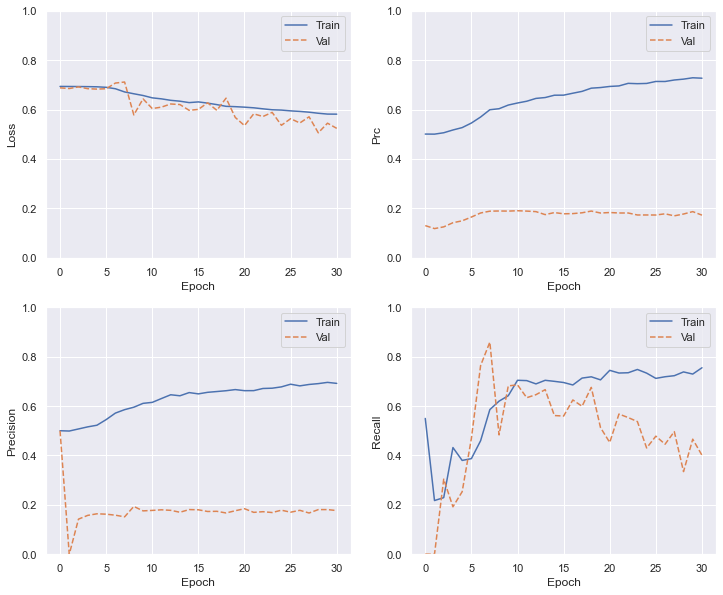

In [195]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.ylim([0, plt.ylim()[1]])
    if metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

loss :  0.6039199446082546
tp :  674.0
fp :  3121.0
tn :  4206.0
fn :  309.0
accuracy :  0.5872443
precision :  0.17760211
recall :  0.68565613
auc :  0.66733193
prc :  0.19044262

Legitimate Transactions Detected (True Negatives):  4206
Legitimate Transactions Incorrectly Detected (False Positives):  3121
Fraudulent Transactions Missed (False Negatives):  309
Fraudulent Transactions Detected (True Positives):  674
Total Fraudulent Transactions:  983


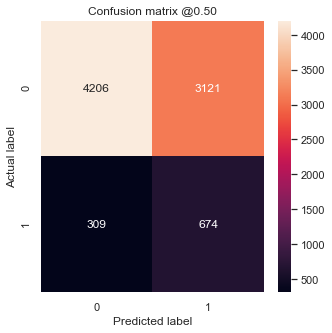

In [164]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
train_predictions_weighted = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = model.predict(X_test, batch_size=BATCH_SIZE)

results = model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

plot_cm(y_test, test_predictions_weighted)

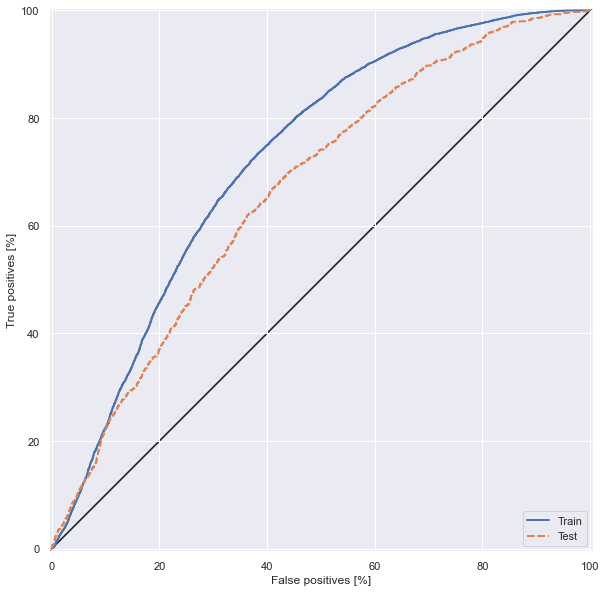

In [165]:
import sklearn

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  ax.set_aspect('equal')
  ax.set_xlim(lims)
  ax.set_ylim(lims)

plot_roc("Train", y_train, train_predictions_weighted, color=colors[0])
plot_roc("Test", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

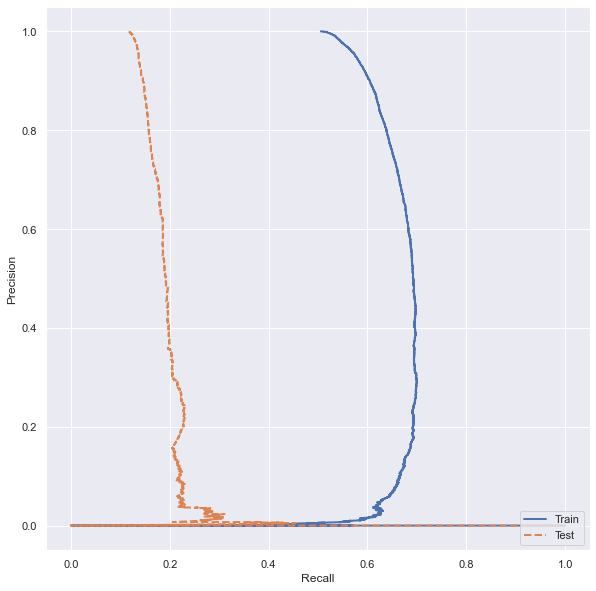

In [166]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Train", y_train, train_predictions_weighted, color=colors[0])
plot_prc("Test", y_test, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

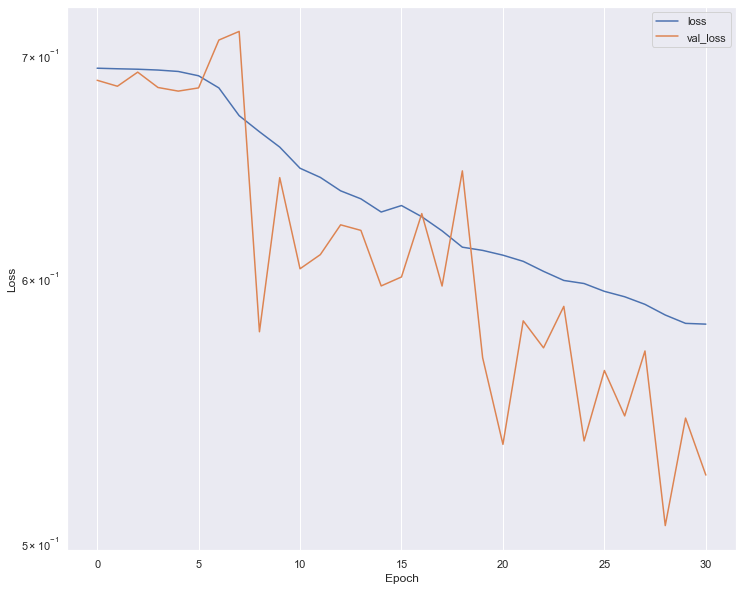

In [167]:
plt.semilogy(history.epoch,history.history['loss'])
plt.semilogy(history.epoch,history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

In [168]:
min(model.predict(X_test))[0],max(model.predict(X_test))[0]

(0.029206932, 0.71718776)

In [169]:
(min(model.predict(X_test))[0]+max(model.predict(X_test))[0])/2

0.3731973469257355

In [170]:

model.predict(X_test)

array([[0.41365921],
       [0.3519637 ],
       [0.1967032 ],
       ...,
       [0.60531855],
       [0.3308338 ],
       [0.35801074]], dtype=float32)

model.save('MODELS/')

In [210]:
%%time
_edge = (min(model.predict(X_test))[0]+max(model.predict(X_test))[0])/2
yhat = pd.DataFrame()
PREDICTAT = []
PREDICT = model.predict(X_test)
for i in tqdm(range(len(PREDICT))):
    if PREDICT[i] <= _edge:
        PREDICTAT.append(0)
    else:
        PREDICTAT.append(1)
yhat['Predict'] = PREDICTAT

TEST = []
for j in tqdm(range(len(y_test))):
    if y_test[j] == 0.:
        TEST.append(0)
    else:
        TEST.append(1)
y_test = TEST


100%|██████████| 8310/8310 [00:00<00:00, 1927269.35it/s]CPU times: user 1.03 s, sys: 202 ms, total: 1.23 s
Wall time: 841 ms



In [211]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1]*100,'%')
print("Test Precision:", score[2]*100,'%')
print("Test Recall:", score[3]*100,'%')

Test Score: 0.6039199423273548
Test Accuracy: 67400.0 %
Test Precision: 312100.0 %
Test Recall: 420600.0 %


In [212]:
len(PREDICT),len(X_test),len(y_test)

(8310, 8310, 8310)

In [213]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

#y_test = y_test.reshape(-1,)
yhat = yhat.Predict

accu = round(accuracy_score(y_test, yhat) * 100,2)
prec = round(precision_score(y_test, yhat, labels=[0,1],pos_label=1) * 100,2)
recall = round(recall_score(y_test, yhat) * 100,2)
f1 = round(f1_score(y_test, yhat) * 100,2)


print('Signaux - Accuracy :' ,accu,'%')
print('Signaux - Precision :',prec,'%')
print('Signaux - Recall :', recall,'%')
print('Achat - F-measure: :' ,f1,'%')
print('\n')
print(classification_report(y_test, yhat))
conf_matrix = pd.DataFrame(columns=['Positifs','Négatifs'])
_tn, _fp, _fn, _tp = confusion_matrix(y_test, yhat).ravel()    #_model.classes_)

conf_matrix.loc['Positifs'] = [_tp,_fn]
conf_matrix.loc['Négatifs'] = [_fp,_tn]

print(conf_matrix)
print()
print(col.Fore.BLUE,'Signaux pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)

_prec = round((_tp/(_tp+_fp))*100,2)
_rec = round((_tp/(_tp+_fn))*100,2)
_f1 = round((2 * _prec * _rec) / (_prec + _rec),2)

print('Vrais signaux positifs trouvés    : ',_tp)
print('Vrais signaux positifs non trouvé :',_fn)
print('Total des signaux posistifs :',_tp+_fn)

if _prec > 69 :
    print(col.Fore.GREEN,'Précision :',_prec,'%',col.Style.RESET_ALL)
elif _prec < 51 :
    print(col.Fore.RED,'Précision :',_prec,'%',col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW,'Precision : ',_prec,'%')
if _rec > 69  :
    print(col.Fore.GREEN,'Recall :',_rec,'%',col.Style.RESET_ALL)
elif _rec < 51  :
    print(col.Fore.RED,'Recall :',_rec,'%',col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW,'Recall',_rec,'%',col.Style.RESET_ALL)
if _f1 > 69  :
    print(col.Fore.GREEN,'F-Score :',_f1,'%',col.Style.RESET_ALL)
elif _f1 < 51  :
    print(col.Fore.RED,'F-Score :',_f1,'%',col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW,'F-Score',_f1,'%',col.Style.RESET_ALL)

print('\n')
print('Vrais signaux négatifs trouvés    : ',_tn)
print('Vrais signaux négatifs non trouvé :',_fp)
print('Total des signaux négatifs :',_tn+_fp)

_prec = round((_tn/(_tn+_fn))*100,2)
_rec = round((_tn/(_tn+_fp))*100,2)
_f1 = round((2 * _prec * _rec) / (_prec + _rec),2)

if _prec > 69 :
    print(col.Fore.GREEN,'Précision :',_prec,'%',col.Style.RESET_ALL)
elif _prec < 51 :
    print(col.Fore.RED,'Précision :',_prec,'%',col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW,'Precision : ',_prec,'%')
if _rec > 69  :
    print(col.Fore.GREEN,'Recall :',_rec,'%',col.Style.RESET_ALL)
elif _rec < 51  :
    print(col.Fore.RED,'Recall :',_rec,'%',col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW,'Recall',_rec,'%',col.Style.RESET_ALL)
if _f1 > 69  :
    print(col.Fore.GREEN,'F-Score :',_f1,'%',col.Style.RESET_ALL)
elif _f1 < 51  :
    print(col.Fore.RED,'F-Score :',_f1,'%',col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW,'F-Score',_f1,'%',col.Style.RESET_ALL)


Signaux - Accuracy : 43.71 %
Signaux - Precision : 15.42 %
Signaux - Recall : 83.83 %
Achat - F-measure: : 26.05 %


              precision    recall  f1-score   support

           0       0.95      0.38      0.55      7327
           1       0.15      0.84      0.26       983

    accuracy                           0.44      8310
   macro avg       0.55      0.61      0.40      8310
weighted avg       0.85      0.44      0.51      8310

                   Positifs Négatifs
Positifs (estimés)      824      159
Négatifs (estimés)     4519     2808

 Signaux pour  EUR/USD 
Vrais signaux positifs trouvés    :  824
Vrais signaux positifs non trouvé : 159
Total des signaux posistifs : 983
 Précision : 15.42 % 
 Recall : 83.83 % 
 F-Score : 26.05 % 


Vrais signaux négatifs trouvés    :  2808
Vrais signaux négatifs non trouvé : 4519
Total des signaux négatifs : 7327
 Précision : 94.64 % 
 Recall : 38.32 % 
 F-Score 54.55 % 


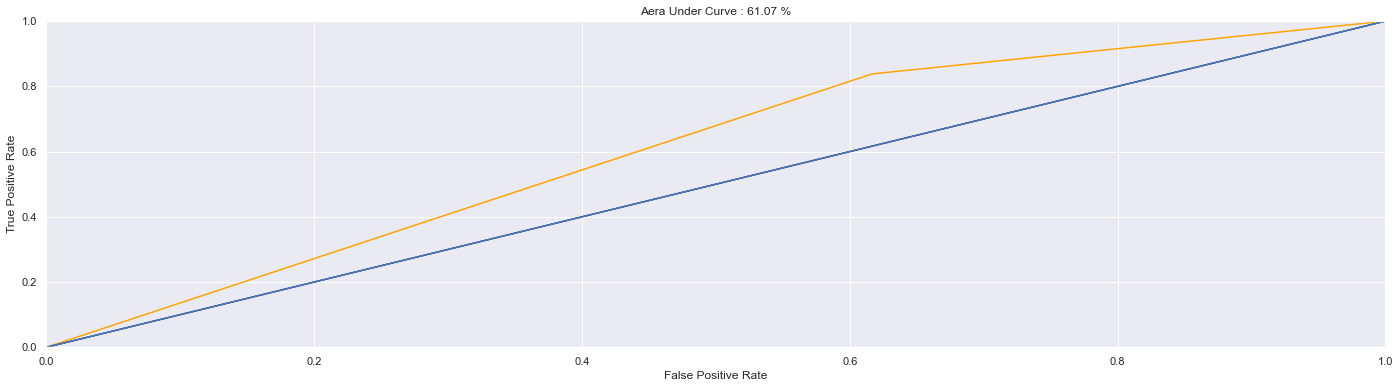

In [175]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr , tpr , thresholds = roc_curve ( y_test, yhat)
auc_score = roc_auc_score(y_test, yhat) * 100
def plot_roc_curve(fpr,tpr):
    plt.figure(figsize=(24,6))
    plt.title("Aera Under Curve : "+str(round(auc_score,2))+' %')
    plt.plot(fpr,tpr,c='orange')
    plt.axis([0,1,0,1]) 
    plt.plot(y_test,y_test)
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    
  
plot_roc_curve (fpr,tpr) 

## TEST ON OOS

In [70]:
%%time
labase = joblib.load('BASES/EURUSD_m5')
print(labase.shape)
labase = strategy(labase)

#labase = labase[labase.Signal!=0]
print(labase.shape)
train, test, oos = split_df(labase)
#oos = oos.drop(['Symbol','DateIndex','SB_Gamma'],axis=1)
#test = test.drop(['Symbol','DateIndex','SB_Gamma'],axis=1)
#train = train.drop(['Symbol','DateIndex','SB_Gamma'],axis=1)

(820907, 63)
(820907, 60)
CPU times: user 943 ms, sys: 467 ms, total: 1.41 s
Wall time: 1.39 s


In [71]:
scaler = MinMaxScaler()
oos.sort_index(inplace=True)
oos = klines(oos)
for i in oos.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid' and i!= 'TRACKER':
        oos[i] = scaler.fit_transform(oos[i].values.reshape(-1,1))

oos = oos.dropna()
oos= oos.reindex(natsorted(oos.columns), axis=1)

test.sort_index(inplace=True)
test = klines(test)
for i in test.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid' and i!= 'TRACKER':
        test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))

test = test.dropna()
test= test.reindex(natsorted(test.columns), axis=1)

train.sort_index(inplace=True)
train = klines(train)
for i in train.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid' and i!= 'TRACKER':
        train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))

train = train.dropna()
train= train.reindex(natsorted(train.columns), axis=1)

In [72]:
X_oos = oos.copy()
X_test = test.copy()
X_train = train.copy()

In [73]:
for tt in X_oos.columns:
    if tt not in df_train.columns:
        print(tt)
for tt in X_test.columns:
    if tt not in df_train.columns:
        print(tt)
for tt in X_train.columns:
    if tt not in df_train.columns:
        print(tt)

ADR_High
ADR_Low
ATR_14
CloseShift_daily
CloseShift_weekly
HighShift_daily
HighShift_weekly
LowShift_daily
LowShift_weekly
LowerBand
ONHISMA_21
ONHISMA_34
ONLOSMA_21
ONLOSMA_34
OpenShift_daily
OpenShift_weekly
PP
R38
R62
R78
R100
R138
R162
R178
R200
RSI_2_hourly
RSI_14_hourly
RVI
S38
S62
S78
S100
S138
S162
S178
S200
SMA_200
UpperBand
ADR_High
ADR_Low
ATR_14
CloseShift_daily
CloseShift_weekly
HighShift_daily
HighShift_weekly
LowShift_daily
LowShift_weekly
LowerBand
ONHISMA_21
ONHISMA_34
ONLOSMA_21
ONLOSMA_34
OpenShift_daily
OpenShift_weekly
PP
R38
R62
R78
R100
R138
R162
R178
R200
RSI_2_hourly
RSI_14_hourly
RVI
S38
S62
S78
S100
S138
S162
S178
S200
SMA_200
UpperBand
ADR_High
ADR_Low
ATR_14
CloseShift_daily
CloseShift_weekly
HighShift_daily
HighShift_weekly
LowShift_daily
LowShift_weekly
LowerBand
ONHISMA_21
ONHISMA_34
ONLOSMA_21
ONLOSMA_34
OpenShift_daily
OpenShift_weekly
PP
R38
R62
R78
R100
R138
R162
R178
R200
RSI_2_hourly
RSI_14_hourly
RVI
S38
S62
S78
S100
S138
S162
S178
S200
SMA_200
Up

In [74]:
%%time
X_oos= X_oos.reindex(natsorted(X_oos.columns), axis=1)
print(len(model.predict(X_oos.drop(['Signal'],axis=1))))
X_oos['Valid'] = model.predict(X_oos.drop(['Signal'],axis=1))

#X_oos = strategy(X_oos)


_condition0 = X_oos.Valid <= 0.5

X_oos['Valid'] = np.where(_condition0,0,1)

_condition1 = ((X_oos.Signal == 1) & (X_oos.Valid == 1))
_condition2 = ((X_oos.Signal == -1) & (X_oos.Valid == 1))

X_oos['FinalSignal'] = np.where(_condition1,1,np.where(_condition2,-1,0))



X_test= X_test.reindex(natsorted(X_test.columns), axis=1)
print(len(model.predict(X_test.drop(['Signal'],axis=1))))
X_test['Valid'] = model.predict(X_test.drop(['Signal'],axis=1))

#X_test = strategy(X_test)

_edge = (min(model.predict(X_test))[0]+max(model.predict(X_test))[0])/2

_condition0 = X_test.Valid <= _edge

X_test['Valid'] = np.where(_condition0,0,1)

_condition1 = ((X_test.Signal == 1) & (X_test.Valid == 1))
_condition2 = ((X_test.Signal == -1) & (X_test.Valid == 1))

X_test['FinalSignal'] = np.where(_condition1,1,np.where(_condition2,-1,0))


X_train= X_train.reindex(natsorted(X_train.columns), axis=1)
print(len(model.predict(X_train.drop(['Signal'],axis=1))))
X_train['Valid'] = model.predict(X_train.drop(['Signal'],axis=1))

#X_train = strategy(X_train)


_condition0 = X_train.Valid <= 0.5

X_train['Valid'] = np.where(_condition0,0,1)

_condition1 = ((X_train.Signal == 1) & (X_train.Valid == 1))
_condition2 = ((X_train.Signal == -1) & (X_train.Valid == 1))

X_train['FinalSignal'] = np.where(_condition1,1,np.where(_condition2,-1,0))

ValueError: Error when checking input: expected dense_2_input to have shape (32,) but got array with shape (63,)

In [186]:
X_test.Valid.sum()

26634.473

In [187]:
len(X_test.query('Valid==1 & Signal==1')),len(X_test.query('Valid==1 & Signal==-1')),len(X_test.query('Signal==1')),len(X_test.query('Signal==-1')),len(X_test),len(X_test.query('Valid==0')),len(X_test.query('Valid==1'))

(0, 0, 4146, 4164, 180844, 0, 0)

In [188]:
%%time
df_ttrain, df_ttest, df_oos = split_df(df_raw)
df_oos['Signal'] = X_oos.FinalSignal
df_ttest['Signal'] = X_test.FinalSignal
df_ttrain['Signal'] = X_train.FinalSignal

AttributeError: 'DataFrame' object has no attribute 'FinalSignal'

In [189]:
len(oos),len(X_oos),len(df_oos)

(168565, 168565, 168565)

In [190]:
df_ttest[df_ttest.Signal==1].Signal.sum()+df_ttest[df_ttest.Signal==-1].Signal.sum(),df_ttest.shape

(-18, (180844, 66))

In [191]:
_nb_bougie_exit = 555555555
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 1
_trigger_rsi = 0
_verbose = 0
_cash_ini = 200000
_target = 0.002
_sl = 0.001
_exposure = 1
_rate = df_ratefx.loc[x[4:],'rate']
_size = _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0
_year_bottom = df_ttrain.index[0]
_year_top = df_ttrain.index[-1]
_verbose = 0
_,_ = bt(df_ttrain,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)



_________________________________________________

__________________________________
     ___ Period 1 : =>  m5  ___
     ___ Period 2 : =>  H1  ___
__________________________________
Ca$h Ini : 200000
Date début: 2011-06-20 00:00:00
Date fin : 2016-06-30 00:00:00
Etat verbose : 0
Nombre Bougies Exit : 555555555
Target : 0.002
Stop Loss : 0.001
Trigger Reengage : 0
Trigger Target : 1
Trigger Inverse : 0
Trigger StopLoss : 1
Trigger RSI : 0
Exposure : 1
_bt_report :  0
Verbose :  0
Trigger Spread : 0.025
Save :  0

_________________________________________________


Début des opérations horodatée à 2021-05-26 11:02:10.554645

 _trigger_rsi : 0 


Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1.0 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 365344/365344 [00:25<00:00, 14386.96it/s]
 For ticker  EUR/USD 
 
Total Profit & Loss : $  -487208.26 . En  7617   transactions.
 
Winners Number : 2167 
 
Loosers number : 5450 
BT's executio

In [126]:
actual = [1,1,1,0,0,1,1,1,0,0,1,0,1,0,1,0,1,1,0,1]
estim = [1,0,1,1,0,1,1,1,0,1,1,0,0,0,0,0,1,1,0,1]

In [134]:
print(classification_report(actual, estim))#, target_names=['Pouet', 'Prout']))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.82      0.75      0.78        12

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20



In [143]:
tn, fp, fn, tp = confusion_matrix(actual, estim).ravel()

In [144]:
confusion_matrix(actual, estim, labels=[0,1])

array([[6, 2],
       [3, 9]])

In [145]:
confusion_matrix(actual, estim)

array([[6, 2],
       [3, 9]])

In [146]:
tp/(tp+fp), tp/(tp+fn)

(0.8181818181818182, 0.75)